In [11]:
from dataclasses import dataclass, field
from vi import Agent, Config, Simulation, Vector2, HeadlessSimulation
import pygame as pg
import os
import numpy as np
import random
from multiprocessing import Pool
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math

In [12]:
frame_dir = "frames"
os.makedirs(frame_dir, exist_ok=True)
frame_count = 0

def save_frame(screen):
    global frame_count
    pg.image.save(screen, os.path.join(frame_dir, f"frame_{frame_count:05d}.png"))
    frame_count += 1

In [13]:
class RecordingSimulation(Simulation):
    def __init__(self, config):
        super().__init__(config)
        self.frame_count = 0
        os.makedirs("frames", exist_ok=True)

    def after_update(self) -> None:
        # Draw everything to the screen
        self._all.draw(self._screen)

        if self.config.visualise_chunks:
            self.__visualise_chunks()

        # Save current frame as an image
        pg.image.save(self._screen, f"frames/frame_{self.frame_count:05d}.png")

        # Update the screen with the new image
        pg.display.flip()

        self._clock.tick(self.config.fps_limit)

        current_fps = self._clock.get_fps()
        if current_fps > 0:
            self._metrics.fps._push(current_fps)

            if self.config.print_fps:
                print(f"FPS: {current_fps:.1f}")  # noqa: T201

        # Increment a frame counter (you may need to initialize it somewhere)
        self.frame_count += 1


In [14]:
@dataclass
class PPConfig(Config):
    #desired initial populations
    initial_prey: int = 100
    initial_predators: int = 30

    #parameters of the Lotka-Volterra equations
    alpha = 0.009    # slower prey reproduction
    beta = 0.045     # more effective predators
    delta = 1.0     # predator reproduction chance
    gamma = 0.002    # predator death chance

    shelter_occupied_by = None
    leave_probability = 0.01

config = PPConfig(image_rotation = True, movement_speed = 3.0, radius = 25, duration = 60*60*3, fps_limit = 60)
    

In [15]:
class Prey(Agent):
    def on_spawn(self):
        self.flee_strength = 1.5
        self.join_strength = 1.0
        self.state = "Wander"
        self.wander_direction_cooldown = 50
        self.is_occupying_shelter = False
        return super().on_spawn()
    
    def change_position(self):
        self.there_is_no_escape()

        if random.random() < self.config.alpha:
            pass
            self.reproduce()

        if self.is_occupying_shelter:
            return
        
        intersections = list(self.obstacle_intersections(scale = 1.0))

        if intersections and self.config.shelter_occupied_by == None:
            x, y = self.config.window.as_tuple()
            self.pos = Vector2(x//2 ,y//2)
            self.is_occupying_shelter = True
            self.config.shelter_occupied_by = self
        elif intersections and random.random() < self.config.leave_probability:
            x, y = self.config.window.as_tuple()
            self.pos = Vector2(x//2 ,y//2)
            self.is_occupying_shelter = True
            self.config.shelter_occupied_by.is_occupying_shelter = False
            self.config.shelter_occupied_by = self

        flee_force = Vector2(0, 0)

        neighbors = list(self.in_proximity_accuracy())
        

        if any(isinstance(agent, Predator) for agent, _ in neighbors):
            self.state = "Flee"
        else:
            self.state = "Wander"


        if self.state == "Flee":
            self.wander_direction_cooldown = 0
            predators_nerby = [(agent, dist) for agent, dist in neighbors if isinstance(agent, Predator)]
            for predator, dist in predators_nerby:
                if dist == 0:
                    dist = 0.001
                direction = self.pos - predator.pos
                if dist > 0:
                    direction = direction / dist
                force_magnitude = self.flee_strength / dist
                flee_force += direction * force_magnitude
            
            self.move = flee_force
            if self.move.length() > 0:
                self.move = self.move.normalize() * self.config.movement_speed


        elif self.state == "Wander":
            if self.wander_direction_cooldown == 0:
                self.wander_direction_cooldown = 50
                wander_angle = random.uniform(0, 2 * math.pi)
                wander_force = Vector2(1, 0).rotate_rad(wander_angle)
                self.move = wander_force
                if self.move.length() > 0:
                    self.move = self.move.normalize() * self.config.movement_speed
            else:
                self.wander_direction_cooldown -= 1
            
        self.pos += self.move

In [16]:
class Predator(Agent):
    def on_spawn(self):
        self.random_move_strength = 1.0
        self.predator_speed_boost = 1.0
        self.state = "Wander"
        self.wander_direction_cooldown = 0
        return super().on_spawn()
    
    def change_position(self):
        self.there_is_no_escape()
        if random.random() < self.config.gamma:
            self.kill()
            return
        
        attract_force = Vector2(0, 0)

        neighbors = list(self.in_proximity_accuracy())
        prey_nearby = [(agent, dist) for agent, dist in neighbors if isinstance(agent, Prey) and not(agent.is_occupying_shelter)]
        if prey_nearby:
            self.state = "Hunt"
        else:
            self.state = "Wander"

        if self.state == "Hunt":
            self.wander_direction_cooldown = 0
            the_closest_prey, closest_dist = min(prey_nearby, key=lambda x: x[1])
            if closest_dist == 0:
                    closest_dist = 0.001
            direction = the_closest_prey.pos - self.pos
                
            if closest_dist > 0:
                direction = direction / closest_dist

            force_magnitude = 1.0 / closest_dist
            attract_force += direction * force_magnitude
            if random.random() < self.config.beta and the_closest_prey.is_alive():
                the_closest_prey.kill()
                if random.random() < self.config.delta:
                    self.reproduce()
            
            self.move = attract_force

            if self.move.length() > 0:
                self.move = self.move.normalize() * self.config.movement_speed * self.predator_speed_boost
            
                

        elif self.state == "Wander":
            if self.wander_direction_cooldown == 0:
                self.wander_direction_cooldown = 50
                wander_angle = random.uniform(0, 2 * math.pi)
                wander_force = Vector2(1, 0).rotate_rad(wander_angle)
                self.move = wander_force
                if self.move.length() > 0:
                    self.move = self.move.normalize() * self.config.movement_speed * self.predator_speed_boost
            else:
                self.wander_direction_cooldown -= 1
        
        self.pos += self.move

In [17]:
class God(Agent):
    """Class to keep simulation from crashing"""
    def on_spawn(self):
        self.move = Vector2(0,0)
        self.pos = Vector2(0,0)
        return super().on_spawn()
    
    def change_position(self):
        self.there_is_no_escape()

In [10]:
x, y = config.window.as_tuple()
(
    RecordingSimulation(
        config
    )
    .spawn_obstacle("images/Shelter.png", x // 2, y // 2)
    .batch_spawn_agents(config.initial_predators, Predator, images=["images/Predator.png"])
    .batch_spawn_agents(config.initial_prey, Prey, images=["images/Prey.png"])
    .batch_spawn_agents(1, God, images=["images/God.png"])
    .run()
)

KeyboardInterrupt: 

In [18]:
class HeadlessSimulationRefined(HeadlessSimulation):
   def __init__(self, config):
      super().__init__(config)
      self.frame_count = 0
      self.prey_predator_per_frame = []
      self.extinction_frame = None

   def after_update(self) -> None:
        # Increment a frame counter (you may need to initialize it somewhere)
        
        # if self.frame_count % 10 == 0:
        num_prey = len([agent for agent in self._all if isinstance(agent, Prey)])
        num_predator = len([agent for agent in self._all if isinstance(agent, Predator)])
        self.prey_predator_per_frame.append((num_prey, num_predator))
        if self.extinction_frame is None and num_predator == 0:
            self.extinction_frame = self.frame_count
            self.config.alpha = 0.0
        if self.extinction_frame is None and self.frame_count == self.config.duration:
            self.extinction_frame = self.frame_count
        if self.frame_count % 100 == 0:
            print(num_prey, num_predator)
            print(self.config.alpha)
        self.frame_count += 1

      

   def run(self):
        """Run the simulation until it's ended by closing the window or when the `vi.config.Schema.duration` has elapsed."""
        self._running = True

        while self._running:
            self.tick()

        return (self.prey_predator_per_frame, self.extinction_frame)

In [19]:
def run_simulation(config: Config) -> pl.DataFrame:
    return (
        HeadlessSimulationRefined(config)
        .spawn_obstacle("images/Shelter.png", x // 2, y // 2)
        .batch_spawn_agents(config.initial_predators, Predator, images=["images/Predator.png"])
        .batch_spawn_agents(config.initial_prey, Prey, images=["images/Prey.png"])
        .batch_spawn_agents(1, God, images=["images/God.png"])
        .run()
    )

102 30
0.009
127 96
0.009
44 225
0.009
3 230
0.009
1 196
0.009
1 154
0.009
2 122
0.009
2 106
0.009
2 91
0.009
2 82
0.009
3 64
0.009
3 58
0.009
1 53
0.009
1 46
0.009
4 43
0.009
5 37
0.009
19 31
0.009
28 39
0.009
38 45
0.009
53 75
0.009
21 114
0.009
4 116
0.009
3 93
0.009
2 80
0.009
1 70
0.009
2 58
0.009
4 46
0.009
9 46
0.009
13 47
0.009
7 50
0.009
3 44
0.009
2 38
0.009
4 31
0.009
5 29
0.009
2 26
0.009
6 23
0.009
4 21
0.009
9 15
0.009
9 17
0.009
18 17
0.009
35 25
0.009
71 32
0.009
107 63
0.009
89 144
0.009
29 222
0.009
7 212
0.009
1 180
0.009
3 146
0.009
1 125
0.009
1 110
0.009
1 86
0.009
2 75
0.009
3 64
0.009
3 50
0.009
1 47
0.009
3 41
0.009
1 37
0.009
3 27
0.009
7 24
0.009
9 25
0.009
19 22
0.009
29 20
0.009
51 26
0.009
82 51
0.009
76 116
0.009
16 194
0.009
1 183
0.009
1 133
0.009
1 117
0.009
1 97
0.009
3 75
0.009
4 64
0.009
5 58
0.009
16 55
0.009
7 58
0.009
10 51
0.009
2 46
0.009
2 42
0.009
2 36
0.009
4 34
0.009
1 33
0.009
1 24
0.009
8 20
0.009
6 23
0.009
16 18
0.009
28 16
0.009
41 20


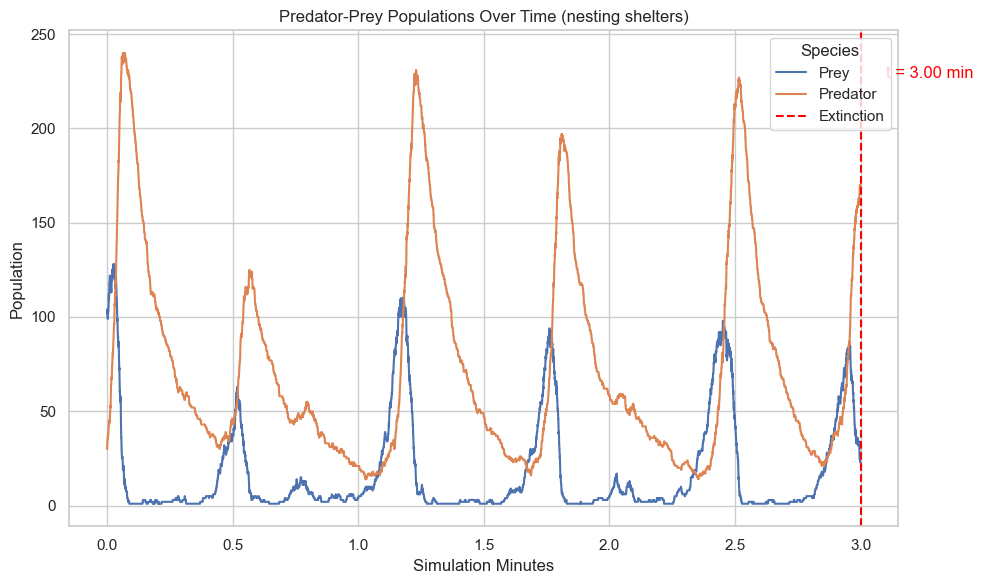

In [20]:
data= run_simulation(config)
extinction_time = data[1] / 3600

df = pd.DataFrame(data[0], columns=['Prey', 'Predator'])

df['Time'] = [t / 3600 for t in range(len(df))]

df_melted = df.melt(id_vars='Time', value_vars=['Prey', 'Predator'],
                    var_name='Species', value_name='Population')
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='Time', y='Population', hue='Species')
plt.title("Predator-Prey Populations Over Time (nesting shelters)")
plt.xlabel("Simulation Minutes")
plt.ylabel("Population")
plt.axvline(x=data[1] / 3600, color='red', linestyle='--', label='Extinction')
plt.text(extinction_time + 0.1,                
         plt.ylim()[1] * 0.9,                  
         f"t = {extinction_time:.2f} min",     
         color='red')
plt.legend(title="Species")
plt.tight_layout()
plt.show()

In [46]:
all_data = []

for run_id in range(30):
    print(f"{run_id * 100 // 30} %")
    config = PPConfig(image_rotation = True, movement_speed = 3.0, radius = 25, duration = 60*60*3, fps_limit = 0)
    history, extinction_time = run_simulation(config)
    
    for t, (prey, predator) in enumerate(history):
        all_data.append({
            'Run': run_id,
            'Time': t,
            'Prey': prey,
            'Predator': predator,
            'ExtinctionTime': extinction_time
        })

# Convert to DataFrame
df = pd.DataFrame(all_data)

# Save to CSV
df.to_csv('simulation_results.csv', index=False)

0 %
100 30
0.009
148 72
0.009
153 203
0.009
20 330
0.009
4 281
0.009
1 240
0.009
1 206
0.009
1 173
0.009
2 138
0.009
1 123
0.009
2 96
0.009
1 73
0.009
1 59
0.009
2 52
0.009
2 47
0.009
7 41
0.009
8 35
0.009
18 26
0.009
32 25
0.009
50 41
0.009
60 69
0.009
39 118
0.009
20 150
0.009
1 152
0.009
1 125
0.009
1 104
0.009
2 90
0.009
4 67
0.009
1 59
0.009
1 45
0.009
2 37
0.009
5 29
0.009
7 27
0.009
8 29
0.009
8 28
0.009
4 29
0.009
9 23
0.009
16 23
0.009
15 27
0.009
16 32
0.009
24 39
0.009
27 54
0.009
31 66
0.009
21 85
0.009
19 86
0.009
15 93
0.009
1 89
0.009
1 75
0.009
3 56
0.009
4 47
0.009
10 39
0.009
9 41
0.009
22 38
0.009
32 47
0.009
31 61
0.009
24 75
0.009
7 87
0.009
4 78
0.009
1 61
0.009
1 50
0.009
2 40
0.009
1 33
0.009
5 26
0.009
8 21
0.009
14 15
0.009
39 14
0.009
96 34
0.009
159 75
0.009
122 250
0.009
14 344
0.009
1 301
0.009
1 246
0.009
1 201
0.009
1 166
0.009
2 140
0.009
1 117
0.009
1 93
0.009
1 73
0.009
1 62
0.009
2 52
0.009
3 37
0.009
1 30
0.009
1 26
0.009
3 26
0.009
2 23
0.009
2 20


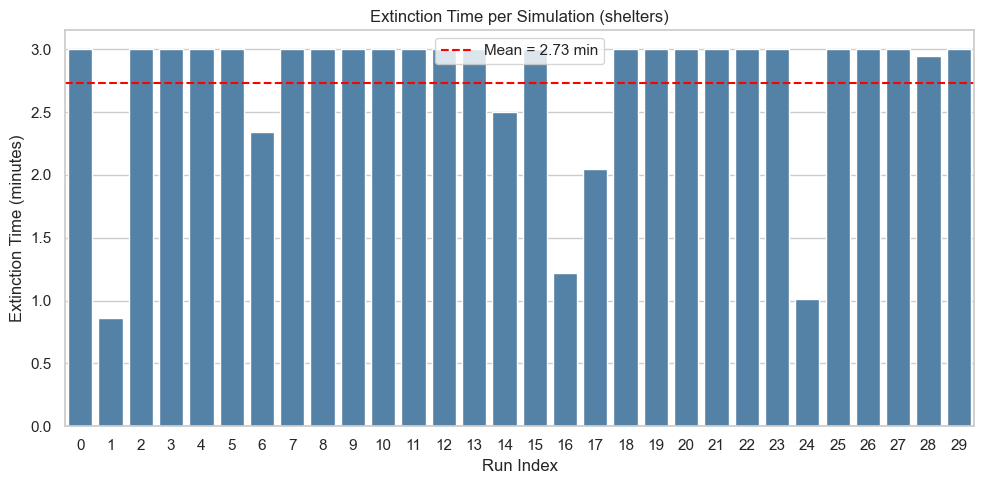

In [47]:
extinction_times = df.groupby('Run')['ExtinctionTime'].first().reset_index()
extinction_times['ExtinctionTimeMin'] = extinction_times['ExtinctionTime'] / 3600

plt.figure(figsize=(10, 5))
sns.barplot(data=extinction_times, x='Run', y='ExtinctionTimeMin', color='steelblue')

mean_ext = extinction_times['ExtinctionTimeMin'].mean()
plt.axhline(mean_ext, color='red', linestyle='--', label=f'Mean = {mean_ext:.2f} min')

plt.title("Extinction Time per Simulation (shelters)")
plt.xlabel("Run Index")
plt.ylabel("Extinction Time (minutes)")
plt.legend()
plt.tight_layout()
plt.show()
